# Opex Variance Analysis

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk import ngrams
from dash import Dash, dcc, html, Input, Output
import plotly.express as px
import dash_bootstrap_components as dbc
from dash_bootstrap_templates import load_figure_template
from sklearn.cluster import KMeans
import os
os.environ['CURL_CA_BUNDLE'] = ''
from sentence_transformers import SentenceTransformer, util
import itertools
import warnings
warnings.filterwarnings("ignore")
#!pip install openpyxl -- uncomment if running for the first time
#also gotta install the other packages as well!

## Converting xlsx file to csv's 

**If you have the CSV'a ignore the code and leave it commented out**  

**If csv's are outdated and you need to unpack an excel file, uncomment the block, replace the "excel_file" with the correct file path and run ONLY ONCE**

**once you have the csv's in the same directory, comment the block out and don't run again!**

In [ ]:
# MAKE SURE THE "excel_file" IS IN THE SAME DIRECTORY!

# excel_file = 'importData/COMMENTARY.xlsx'
# all_sheets = pd.read_excel(excel_file, sheet_name=None)
# sheets = all_sheets.keys()

# for sheet_name in sheets:
#     sheet = pd.read_excel(excel_file, sheet_name=sheet_name)
#     sheet.to_csv("%s.csv" % sheet_name, index=False)

## Reading in the files

In [3]:
mapping = pd.read_csv('importData/ACCOUNT_MAPPING.csv')
current = pd.read_csv('importData/CURRENT.csv')
legacy = pd.read_csv('importData/LEGACY.csv').rename(columns={'NOTE':'COMMENT'})

### Cleaning the comments

In [4]:
def convert(sentence):
    lowercase = sentence.lower()
    cleaned = re.sub("[^\w\d'\s]+",'', lowercase).strip()
    return cleaned

In [5]:
current.dropna(subset=['COMMENT'],inplace=True)
legacy.dropna(subset=['COMMENT'],inplace=True)
current["COMMENT"] = current["COMMENT"].apply(convert) #Only really used the current data! That's what we were interested in
legacy["COMMENT"] = legacy["COMMENT"].apply(convert)
comments = pd.concat([legacy, current], axis = 0, ignore_index = True)
comments = comments.merge(mapping, left_on = 'ACCOUNT_CODE', right_on = 'ACCOUNT_CODE', how = 'left')

### Code to create barchart of keywords per Reason category

In [6]:
def create_barchart(question, phrase_size, k):

    def comments_phrases_dictionary(question, phrase_size):
        df = current[current['REASON'] == question]
        comments = df['COMMENT'].dropna()
        counts = {}
        for sentence in comments:
            lowercase = sentence.lower()
            cleaned = re.sub("[^\w\d'\s]+",'', lowercase).strip()
            if phrase_size == 1:
                words = cleaned.split()
                useless_words = set(stopwords.words('english'))
                for word in words:
                    if word in counts.keys() and word not in useless_words:
                        counts[word] += 1
                    elif word not in counts.keys() and word not in useless_words:
                        counts[word] = 1
            else:
                pairs = list(ngrams(cleaned.split(), phrase_size))
                for pair in pairs:
                    key = " ".join(pair)
                    if key in counts.keys():
                        counts[key] += 1
                    elif key not in counts.keys():
                        counts[key] = 1
        sorted_words = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
        return sorted_words
    
    def top_k_items(k, dictionary):
        top_items = dict(list(dictionary.items())[0:k])
        return top_items

    def top_k_dictionary(question, phrase_size, k):
        words = comments_phrases_dictionary(question, phrase_size)
        top_items = top_k_items(2*k+5, words)
        return top_items
    
    def create_embeddings(top_items):
        sentences = list(top_items.keys())
        counts = list(top_items.values())
        model = SentenceTransformer('paraphrase-MiniLM-L6-v2') #distilbert-base-nli-mean-tokens
        sentence_embeddings = model.encode(sentences)
        sentences_with_embeddings = list(zip(sentences, sentence_embeddings, counts))
        return sentences_with_embeddings, sentences
    
    def delete_similar_phrases(phrases_embeddings, sentences):
        kept = dict.fromkeys(sentences, True)
        combos = list(itertools.combinations(phrases_embeddings, 2))
        for combo in combos:
            if kept[combo[0][0]] == False or kept[combo[1][0]] == False:
                continue
            similarity = util.pytorch_cos_sim(combo[0][1], combo[1][1]).item()
            if similarity >= 0.85:
                if combo[1][2] > combo[0][2]:
                    kept[combo[0][0]] = False
                else:
                    kept[combo[1][0]] = False
        return kept
       
    def reformat(reduced, original_dict, k):
        final_phrases = []
        for key, value in reduced.items():
            if value == True:
                final_phrases.append(key)
        filtered_dict = {}
        for phrase in final_phrases:
            filtered_dict[phrase] = original_dict[phrase]
        return dict(list(filtered_dict.items())[0:k])
    
    top_items = top_k_dictionary(question, phrase_size, k)
    sentences_with_embeddings, sentences = create_embeddings(top_items)
    kept_dictionary = delete_similar_phrases(sentences_with_embeddings, sentences)
    reduced_dictionary = reformat(kept_dictionary, top_items, k)
    
    return reduced_dictionary

In [9]:
app = Dash(__name__, external_stylesheets=[dbc.themes.DARKLY])
style = {'margin-left':'7px', 'margin-top':'7px'}
sidebar_style = {
    "position": "fixed",
    "top": 0,
    "left": 0,
    "bottom": 0,
    "width": "22rem",
    "padding": "1rem 1rem",
    "background-color": "black",
}

sidebar = html.Div([
        html.H2("Options"),
        html.Hr(),
        html.P(
            "Choose values for each option below", className="lead"
        ),
        dbc.Nav(
            [
                question_input := dcc.Dropdown(id='Select Question', options=current['REASON'].unique(), value='Other'),
                html.Br(),
                size_input := dcc.Input(type='number', value=3, min=1, max=10),
                html.Br(),
                k_input := dcc.Input(type='number', value=20, min=1, max=50)
            ],
            vertical=True,
            pills=True,
        ),
    ],
    style=sidebar_style,
)

app.layout = html.Div(children = [
                dbc.Row([
                    dbc.Col(),
                    dbc.Col(html.H1('Common Phrases per Reason'), width = 9, style = {'margin-left':'7px','margin-top':'7px'})
                    ]),
                dbc.Row(
                    [dbc.Col(sidebar),
                     dbc.Col(gr := dcc.Graph(id = 'graph2', figure = {}), width = 9, style = {'margin-left':'15px', 'margin-top':'7px', 'margin-right':'15px'})
                    ])
    ]
)

@app.callback(
    Output(gr, component_property='figure'),
    Input(question_input, 'value'),
    Input(size_input, 'value'),
    Input(k_input, 'value')
)
def update_graph(question_value, size_value, k):
    top_items = create_barchart(question_value, size_value, k)
    data = pd.DataFrame(list(top_items.items()), columns=['phrase', 'count'])
    fig = px.bar(data, x='phrase', y='count')
    fig.show()
    fig.update_layout(mapbox_style='carto-positron')
    return fig

load_figure_template('DARKLY')

if __name__ == '__main__':
    app.run_server(debug=False, jupyter_mode="external")

Dash app running on http://127.0.0.1:8050/


In [10]:
def create_clusters(data, question, num_clusters):

    def comments_list(data, question):
        if question != '':
            df = data[data['REASON'] == question]
        else:
            df = data.copy()
        comments = df['COMMENT'].dropna().unique()
        sentences = []
        for sentence in comments:
            lowercase = sentence.lower()
            cleaned = re.sub("[^\w\d'\s]+",'', lowercase).strip()
            sentences.append(cleaned)
        return sentences
    
    def create_embeddings(sentences):
        model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
        sentence_embeddings = model.encode(sentences)
        return sentence_embeddings
    
    def clusters(sentences, sentence_embeddings, num_clusters):
        clustering_model = KMeans(n_clusters=num_clusters)
        clustering_model.fit(sentence_embeddings)
        cluster_assignment = clustering_model.labels_
        for i in range(num_clusters):
            print()
            print(f'Cluster {i + 1} contains:')
            clust_sent = np.where(cluster_assignment == i)
            for k in clust_sent[0]:
                print(f'- {sentences[k]}')
    
    sentences = comments_list(data, question)
    sentence_embeddings= create_embeddings(sentences)
    final_clusters = clusters(sentences, sentence_embeddings, num_clusters)
    
    return final_clusters

In [11]:
post_depreciation = ['post depr', 'depreciation', 'depr']
repairs = ['repairs', 'repair', 'repaired', 'repairing', 'contingencies', 'contingency', 'replaced', 'replace',
            'replacement', 'rpr', 'leak', 'break', 'emergency', 'pm', 'preventative', 'prevent']
damages = ['damage', 'damages', 'tt damages', 'tt damage', 'tt damaged', 'mo damages', 'mo damage', 'move out damage', 'move out damages', 'moveout']
weather_related = ['weatherasphalt', 'season', 'rain', 'rainy', 'snow', 'rains', 'storm', 'stormy', 'storms', 'weather', 'winter', 'heavy', 'snowfall', 'deicing', 'freezing']
timing_string = "timing, delay, delays, delayed, q1, q2, q3, q4, until, deferred, january, february, march, april, may, june, july, august, september, october, november, december, not yet completed, not completed yet, not yet, months, pending, 5 year, 5 yr, scheduled, fall, spring, summer"
timing = timing_string.split(", ")

reclass = ['reclass', 'reclassed', 'move to', 'not in gl', 'in gl', 'moved to', 'gls', 'allocated', 'coded', 'coding']
gl_code_mapping = ['gl code', 'gl code mapping', 'gl mapping', 'be mapped to']
unbudgeted_string = "unbudgeted, not budgeted, underbudgeted, incorrectinflated, incorrectly budgeted, less than budgeted, more than budgeted, higher than budgeted, lower than budgeted, budget not utilized, nothing budgeted"
unbudgeted = unbudgeted_string.split(", ")

usage_cost_change_string = "utility, usage, expected, less than budgeted, repairs than anticipated, lower than anticipated, higher than anticipated, less than anticipated, higher than anticipated, repairs than expected, costs, electric, electrical" #(how to deal with "less repairs than expected", "more snowfall than expected")
usage_cost_change = usage_cost_change_string.split(", ")

vendor_change_string = "vendors, vendor, switching, switch, provider, transition, transitioned, landscaper, now participates, changes from, changes to, changed"
vendor_change = vendor_change_string.split(", ")

accruals = ['accruals', 'accrual', 'reversal', 'reversals', 'accural', 'accurals', 'accrued', 'timing', 'actual is', 'not yet', 'pending']
occupancy = ['vacant', 'vacancy', 'vacancies', 'vacating', 'occupancy', 'occupied', 'tenant', 'tenants']
id_plans = ['id plan', 'site', 'ratvi']

reasons = {'Post Depreciation': post_depreciation,
           'Accruals': accruals,
           'Reclass': reclass,
           'Timing': timing,
           'Weather Related': weather_related,
           'Damages': damages,
           'Contingency/Emergency Repairs': repairs,
           'GL Code Mapping': gl_code_mapping,
           'Unbudgeted': unbudgeted,
           'Change in usage/cost': usage_cost_change,
           'Vendor/Provider Change': vendor_change,
           'Occupancy': occupancy
           }

NOTE: I didn't change the Non "Other" categories. There are some comments in accruals that just say timing so maybe we should those to the timing category?

In [11]:
def remap(row):
    if row["REASON"] == "Other":
        for key, value in reasons.items():
            for phrase in value:
                object = re.search("\\b" + phrase + "\\b", row["COMMENT"])
                if object != None:
                    return key
        return "Other"
    else:
        return row["REASON"]

In [12]:
opex = pd.read_csv('importData/Sheet1.csv')
opex.head(5)

,Unnamed: 0,PROPERTY_ID,PROPERTY_CODE,PERIOD,ACCOUNT_CODE,ACCOUNT_DESCRIPTION,REASON,NEW_REASON,VANESSA NEW REASON,STATUS,NEW_STATUS,COMMENT,CREATED_ON,CREATED_BY,MODIFIED_ON,MODIFIED_BY,CHARGE_CATEGORY,CHARGE_CATEGORY.1
0,0,2705,br35084,23Q2,50230000,[CAM] Property Manager Direct Charges - External,Reclass,Reclass,Reclass,Temporary,NaN,reclass from 50210000 to 50230000,2023-07-06 20:58:39,Stuart Pechner,2023-07-06 20:58:39,Stuart Pechner,Property Administrative Fees,Common Area Maintenance
1,1,11460,br46637,23Q2,50905000,[CAM] Contract Landscaping - Recurring,Vendor/Provider Change,Vendor/Provider Change,Timing,Temporary,NaN,timingvariance caliber invoices approved and posting shortly,2023-07-06 22:43:12,Ryan Piercy,2023-07-13 19:49:42,Ryan Piercy,Landscaping,Common Area Maintenance
2,2,11694,bt46803,23Q2,50105000,[CAM] Security,Contingency/Emergency Repairs,Contingency/Emergency Repairs,NaN,Temporary,NaN,temporary watch 1028110322,2023-07-06 23:05:23,Brooke Kasperkhan,2023-07-06 23:12:59,Brooke Kasperkhan,Security,Common Area Maintenance
3,3,11694,bt46803,23Q2,50305025,[CAM] Plumbing and Sewer,Contingency/Emergency Repairs,Contingency/Emergency Repairs,Contingency/Emergency Repairs,Temporary,NaN,unforseen plumbing repairs needed to sewer line,2023-07-06 23:13:40,Brooke Kasperkhan,2023-07-06 23:13:40,Brooke Kasperkhan,General Building Maintenance,Common Area Maintenance
4,4,126126,br44196,23Q2,50321000,[CAM] Roof Repairs,Weather Related,Weather Related,Weather Related,Permanent,NaN,due to unprecedented rainy season,2023-07-07 06:25:58,Lucy Mao,2023-07-07 06:25:58,Lucy Mao,Roof R&M,Common Area Maintenance


In [13]:
opex["NEW_REASON"] = opex.apply(lambda row: remap(row), axis = 1)

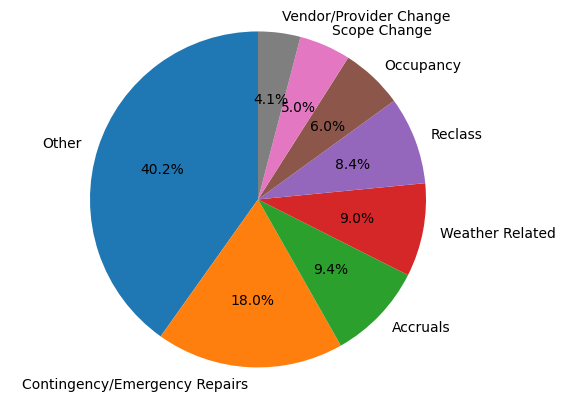

In [14]:
labels = list(opex["REASON"].value_counts().index)
sizes = list(opex["REASON"].value_counts().values)

plt.pie(sizes,labels=labels, startangle=90, autopct='%1.1f%%')
plt.axis('equal')
plt.show()

In [18]:
create_clusters(current, "Other", 20)

C:\Users\STalanki\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning




Cluster 1 contains:
- gl code mapping issue
- gl mapping
- due to cap improvements being moved to their appropriate gl
- roof  gl code mapping issue
- due to cap improvements being moved to their appropriate gl gl code mapping issue
- noncontrollable gl
- due to post depreciation  cap improvements being moved to their appropriate gl and gl code mapping issue
- unbudgeted gl originally budgeted to gl 50390 general building maintenance
- unbudgeted gl
- no expenses for this gl
- capital improvement moved to gl code for amortization
- capital improvements post to gl code
- gl mapping issues
- roof gl code mapping issue
- roof gl mapping issue
- bi incorrect  yardi shows 8320 is budgeted in this gl code
- gl code mapping
- gl code mapping issues
- gl code mapping change between 2023 budget and actuals
- bugeted in the wrong gl code should be 50811001
- gl code mapping issue  annual maintenance was busgeted for
- gl mapping issue
- gl  code mappting issue
- budgeted sweeping in this gl in 

### Notes

timing/delays, gl mapping, unbudgeted/incorrectly budgeted, mistake in anticipated costs, post depreciation, mistake in anticipated usage

notes -

Other - 

Contingency/Emergency Repairs - repairs, repair, repaired, repairing, contingencies, contingency, replaced, replace, replacement, rpr, leak, break, emergency, pm, preventative
    
Weather Related- season, rain, rainy, snow, rains, storm, stormy, storms, weather, winter, heavy, snowfall, deicing, ice, freezing, event

Reclass - reclass, reclassed, move to, not in gl, in gl, moved to, gls, allocated, coded, code, coding, (maybe "incorrect")
                           
Occupancy - vacant, vacancy, vacancies, vacating, occupancy, occupied, tenant, tenants, TT (potentially include usage A LOT OF USAGE IN HERE - usage, expected, anticipated)

Accruals - accruals, accrual, reversal, reversals, accural, accurals, accrued, timing, actual is, not yet utilized

Scope Change - Don't do
                   
Vendor/Provider Change - vendors, vendor, switching, switch, service, services, provider, transition, transitioned, landscaper, landscape, now participates, changes from, changes to, changed

id plans, site plans, ratvi/HVAC

fire watch, should've been coded to diff gl code

There are many types of repairs, maybe the commenters didn't think they were considered "Contigency/Emergency Repairs"

tenant damages ? damages (might be abbreviated as tt damages)

Budget not utilized YTD
Additional PM work not budgeted for.
post depriciation
UNDER BUDGET: Due to an incorrect/inflated budget for 2023 water/sewer and PY accrual reversals that posted in January 2023. This GL is likely to remain under budget for the entire year as we have received a full six (6) months of expenses for Q1-2023 and Q2-2023.

Usage Difference - utilities, utility, usage, expected, less than budgeted, repairs than anticipated, lower than anticipated, higher than anticipated, less than anticipated, higher than anticipated, repairs than expected, costs (how to deal with "less repairs than expected", "more snowfall than expected"), electric, electrical

damages - damage, damages, tt damages, tt damage

Post Depriciation - post, depreciation, depr

Repairs- repairs, repair, repaired, repairing, contingencies, contingency, replaced, replace, replacement, rpr, leak, break, emergency

Timing - timing, delay, delays, delayed, q1, q2, q3, q4, until, completed, deferred, january, february, march, april, may, june, july, august, september, october, november, december, not yet completed, not completed yet, not yet, months, pending, 5 year, 5 yr,

GL Code Mapping- gl code, gl code mapping, gl mapping issue, 50110000 regex

Unbudgeted - unbudgeted, not budgeted, underbudgeted, incorrectinflated, incorrectly budgeted, less than budgeted, more than budgeted, higher than budgeted, lower than budgeted, budget not utilized, nothing budgeted

budget not utilized to date
pending - accruals

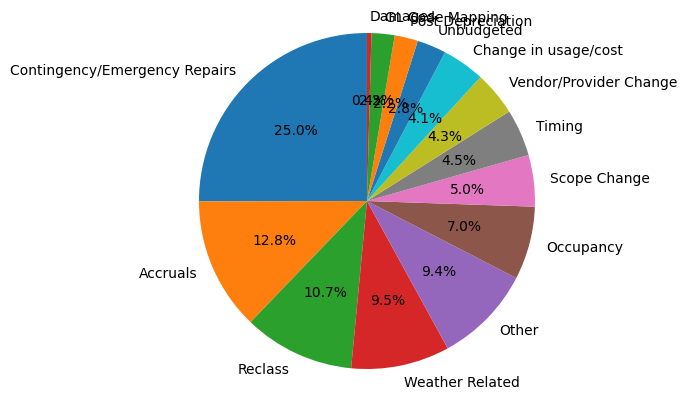

In [15]:
labels = list(opex["NEW_REASON"].value_counts().index)
sizes = list(opex["NEW_REASON"].value_counts().values)

plt.pie(sizes,labels=labels, startangle=90, autopct='%1.1f%%')
plt.axis('equal')
plt.show()

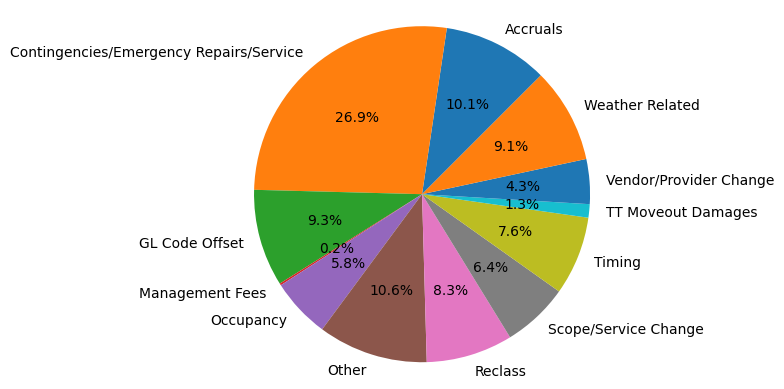

In [16]:
final_categories = "Accruals,Contingencies/Emergency Repairs/Service,GL Code Offset,Management Fees,Occupancy,Other,Reclass,Scope/Service Change,Timing,TT Moveout Damages,Vendor/Provider Change,Weather Related"
final_categories = final_categories.split(",")
final_counts = [997,2649,919,18,566,1040,819,629,746,127,424,898]
plt.pie(final_counts,labels=final_categories, startangle=45, autopct='%1.1f%%')
plt.axis('equal')
plt.show()

Final categories shown above (unsure about Management Fees and TT Moveout Damages)

### Not helpful: Choosing K by manual inspection is more effective!

In [ ]:
def choose_k(data, question, num_clusters):

    def comments_list(data, question):
        if question != '':
            df = data[data['REASON'] == question]
        else:
            df = data.copy()
        comments = df['COMMENT'].dropna().unique()
        sentences = []
        for sentence in comments:
            lowercase = sentence.lower()
            cleaned = re.sub("[^\w\d'\s]+",'', lowercase).strip()
            sentences.append(cleaned)
        return sentences
    
    def create_embeddings(sentences):
        model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
        sentence_embeddings = model.encode(sentences)
        return sentence_embeddings
    
    def clusters(sentences, sentence_embeddings, num_clusters):
        variances=[]
        kmeans=[]
        for i in range(1,num_clusters+1):
            variance=0
            model=KMeans(n_clusters=i).fit(sentence_embeddings)
            cluster_assignment = model.labels_
            kmeans.append(model)
            variances.append(model.inertia_)
        plt.plot(list(range(1,num_clusters+1)), variances)
                
        return variances
    
    sentences = comments_list(data, question)
    sentence_embeddings= create_embeddings(sentences)
    final_clusters = clusters(sentences, sentence_embeddings, num_clusters)
    
    return final_clusters